# Exploratory Data Analysis (EDA)




**Author:** John Doe

**Goal:** perform exploratory data analysis (EDA),

**Notebook standards:** PEP8-style code, modular cells, inline explanations, and reproducible plotting.

## Objectives

1. Understand the structure and quality of the dataset.
2. Identify missing values, outliers, and data inconsistencies.
3. Explore relationships between features and the target variable.
4. Prepare the dataset for modeling by cleaning and transforming it.

  This notebook is organized into sections: Imports → Utilities → Load Data → Data Overview → Cleaning → EDA → Feature Engineering → Summary.

###  Imports

In [1]:
# Standard library imports
import os
from typing import Tuple
import warnings
# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
sns.set_theme(style='whitegrid')
warnings.filterwarnings('ignore')

# Constants
DATA_PATH = r"..\data\raw\premium.xlsx"  # update path if file is located elsewhere




### Utilities

In [3]:
def load_data(path:str) -> pd.DataFrame:
    '''
    Loads data from csv or excel file with safe checks

    Returns data frame
    '''
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found at: {path}. Please place the file in the working directory or update DATA_PATH.")
    if path.lower().endswith('.xlsx') or path.lower().endswith('.xls'):
        df = pd.read_excel(path)
    elif path.lower().endswith('csv'):
        df = pd.read_csv(path)
    else:
        raise ValueError('Unsupported file format. Provide .csv or .xlsx')
    return df

def overview(df: pd.DataFrame, n: int = 5) -> None:
    """Print quick dataset overview: shape, dtypes, head, and missing values."""
    print(f"Shape: {df.shape}\n")
    display(df.head(n))


def set_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names: lowercase, underscores, strip."""
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('-', '_')
    )
    return df




### Load Data

In [4]:
# Load the dataset (update DATA_PATH if necessary)
try:
    df = load_data(DATA_PATH)
    df = set_column_names(df)
    print('Data loaded Successfully.')
except Exception as exec:
    print('Data failed to load',exec)

if not df.empty:
    overview(df)


Data loaded Successfully.
Shape: (50000, 14)



age  gender     region marital_status  number_of_dependants bmi_category smoking_status employment_status  \
0   26    Male  Northwest      Unmarried                     0       Normal     No Smoking          Salaried   
1   29  Female  Southeast        Married                     2      Obesity        Regular          Salaried   
2   49  Female  Northeast        Married                     2       Normal     No Smoking     Self-Employed   
3   30  Female  Southeast        Married                     3       Normal     No Smoking          Salaried   
4   56    Male  Northeast        Married                     3      Obesity     Occasional     Self-Employed   

  income_level  income_lakhs      medical_history insurance_plan  annual_premium_amount  genetical_risk  
0         <10L             6             Diabetes         Bronze                   9053               0  
1         <10L             6             Diabetes         Bronze                  16339               0  
2    10L - 25L            20  High blood pressure         Silver                  18164               0  
3        > 40L            77           No Disease           Gold                  20303               0  
4    10L - 25L            14             Diabetes         Bronze                  15610               0

## Data quality checks

We'll inspect missing values,duplicates, extreme values, and column-level notes.

For each problematic column we'll add a proposed action (impute/transform/remove).

In [7]:
if df.empty:
    print('No data present — please load the file and re-run the cell.')
else:
    # Missing values
    print('Missing Values')
    display(df.isna().sum()) 

    # Duplicates
    dup_count = df.duplicated().sum()
    print(f"Duplicated count: {dup_count}")

    #summary statistics
    display(df.describe(include=[np.number]).T)

    # Cardinality for object columns (top categories)
    object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if object_cols:
        for col in object_cols:
            top = df[col].value_counts(dropna=False).head(10)
            print(f"\nColumn: {col} — unique: {df[col].nunique()}\nTop values:\n{top}\n")
    


Missing Values


age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
genetical_risk            0
dtype: int64

Duplicated count: 0


count         mean          std     min     25%      50%       75%      max
age                    50000.0     34.59348    15.000437    18.0    22.0     31.0     45.00    356.0
number_of_dependants   50000.0      1.71208     1.498248    -3.0     0.0      2.0      3.00      5.0
income_lakhs           50000.0     23.01820    24.219197     1.0     7.0     17.0     31.00    930.0
annual_premium_amount  50000.0  15768.11632  8419.839675  3501.0  8608.0  13929.0  22275.25  43471.0
genetical_risk         50000.0      1.00636     1.637820     0.0     0.0      0.0      2.00      5.0


Column: gender — unique: 2
Top values:
gender
Male      27480
Female    22520
Name: count, dtype: int64


Column: region — unique: 4
Top values:
region
Southeast    17520
Southwest    15152
Northwest    10044
Northeast     7284
Name: count, dtype: int64


Column: marital_status — unique: 2
Top values:
marital_status
Unmarried    25681
Married      24319
Name: count, dtype: int64


Column: bmi_category — unique: 4
Top values:
bmi_category
Normal         23511
Overweight     11556
Underweight     7768
Obesity         7165
Name: count, dtype: int64


Column: smoking_status — unique: 6
Top values:
smoking_status
No Smoking        27366
Regular           15686
Occasional         6915
NaN                  11
Not Smoking           8
Smoking=0             8
Does Not Smoke        6
Name: count, dtype: int64


Column: employment_status — unique: 3
Top values:
employment_status
Salaried         20968
Freelancer       15428
Self-Employed    13602
NaN                  2
Name: count, dtype: int64



## Cleaning strategy (high level)

- Numerical columns: inspect distribution → impute with median or domain-specific cap.
- Categorical columns: fill missing with 'Unknown' or 'Missing' if appropriate, or create a flag column.
- Dates: parse and extract useful features (year, month, age from DOB).
- Outliers: cap using domain-informed thresholds or use percentile capping (1st/99th).

In [8]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """A sample cleaning pipeline."""
    df = df.copy()

    # Removing null values as they are less in number
    df.dropna(inplace=True)

    # Handling duplicated values
    df.drop_duplicates(inplace=True)

    # Handling age values
    df = df[df['age']<=100]

    # Handling negative values in number of dependent column
    df['number_of_dependants'] = abs(df['number_of_dependants']) 

    # smoking column
    df['smoking_status']=df['smoking_status'].apply(lambda row: 'No Smoking' if row not in ['Regular', 'Occasional'] else row )

    # handling the outliers for income_lakhs
    quantile_threshold = df.income_lakhs.quantile(0.999)
    df = df[df['income_lakhs']<=quantile_threshold]

    return df

# Apply cleaning
if not df.empty:
    df_clean = clean_dataframe(df)
    print('Cleaning applied — preview:')
    display(df_clean.head())
else:
    df_clean = df

Cleaning applied — preview:


age  gender     region marital_status  number_of_dependants bmi_category smoking_status employment_status  \
0   26    Male  Northwest      Unmarried                     0       Normal     No Smoking          Salaried   
1   29  Female  Southeast        Married                     2      Obesity        Regular          Salaried   
2   49  Female  Northeast        Married                     2       Normal     No Smoking     Self-Employed   
3   30  Female  Southeast        Married                     3       Normal     No Smoking          Salaried   
4   56    Male  Northeast        Married                     3      Obesity     Occasional     Self-Employed   

  income_level  income_lakhs      medical_history insurance_plan  annual_premium_amount  genetical_risk  
0         <10L             6             Diabetes         Bronze                   9053               0  
1         <10L             6             Diabetes         Bronze                  16339               0  
2    10L - 25L            20  High blood pressure         Silver                  18164               0  
3        > 40L            77           No Disease           Gold                  20303               0  
4    10L - 25L            14             Diabetes         Bronze                  15610               0

### Distribution plots 


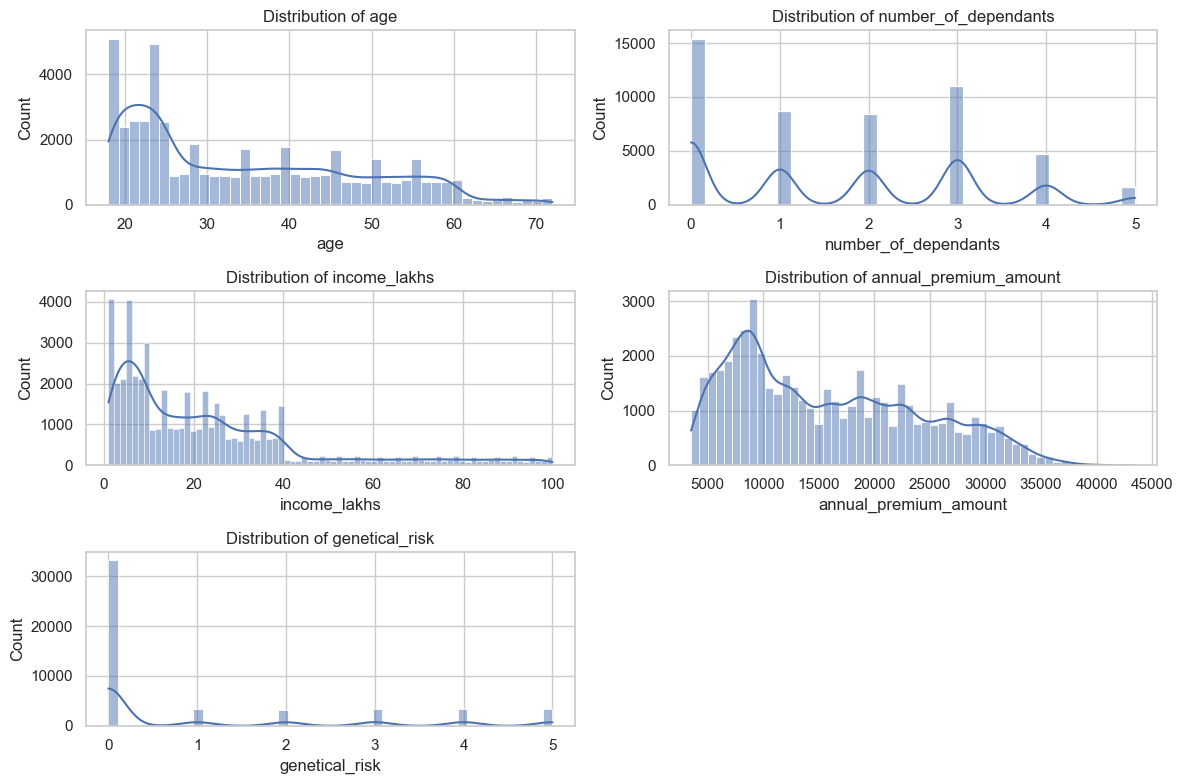

In [9]:
def plot_numerical_distribution(data: pd.DataFrame, columns: list):
    fig, axes = plt.subplots(len(columns) // 2 + len(columns) % 2, 2, figsize=(12, 8))
    axes = axes.flatten()
    for idx, col in enumerate(columns):
        sns.histplot(data[col], ax=axes[idx], kde=True)
        axes[idx].set_title(f'Distribution of {col}')

    # Hide any unused subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


num_cols = df.select_dtypes(exclude='object').columns.tolist()
plot_numerical_distribution(df_clean, num_cols)

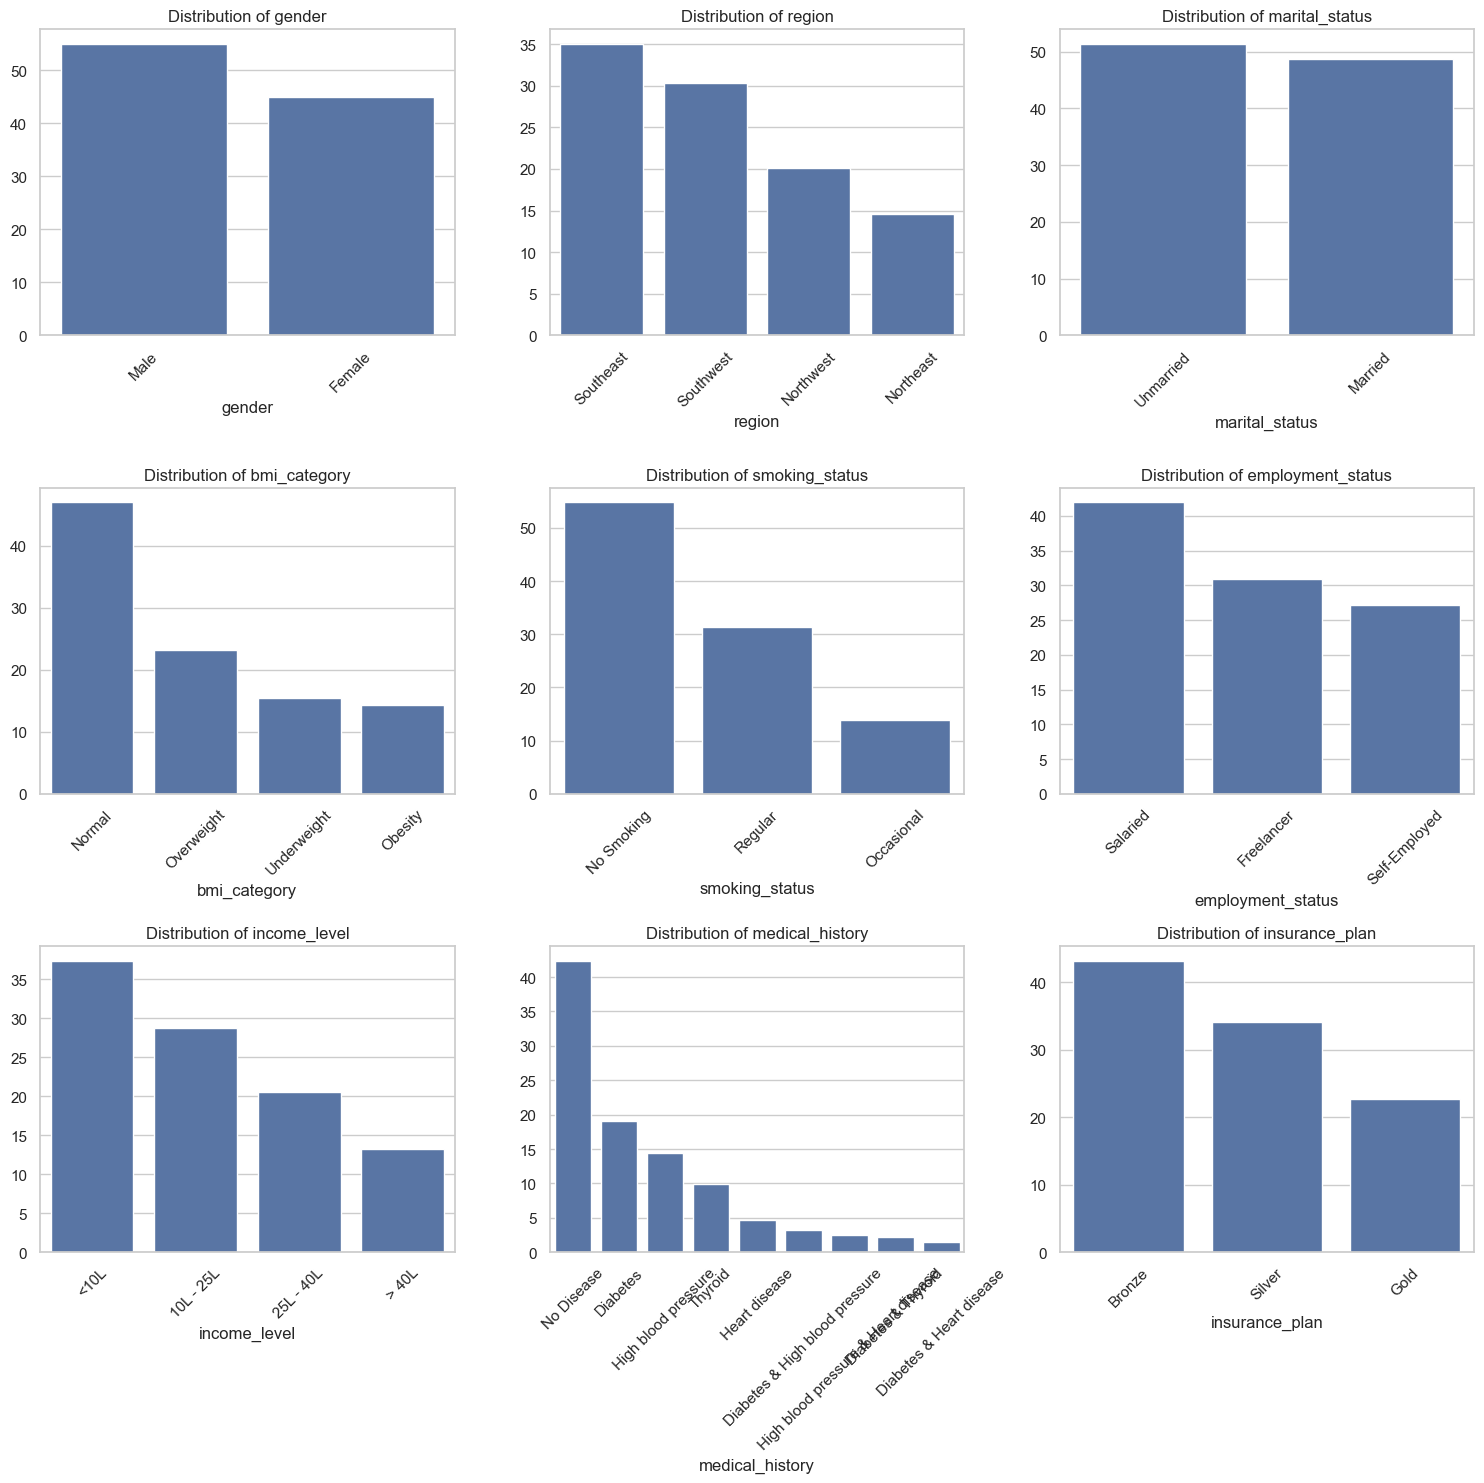

In [10]:
def plot_categorical_distribution(data: pd.DataFrame, columns: list):
    """Plot count plots for categorical columns."""
    n_col = 3
    n_row = (len(columns) // n_col)
    fig, axes = plt.subplots(n_row, n_col, figsize=(15, 5*n_row))
    axes = axes.flatten()
    for idx, col in enumerate(columns):
        cat_count = data[col].value_counts(normalize=True)*100
        plot = sns.barplot(y=cat_count.values,x=cat_count.index,ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

cat_cols = df.select_dtypes('object').columns.tolist()
plot_categorical_distribution(df_clean, cat_cols)

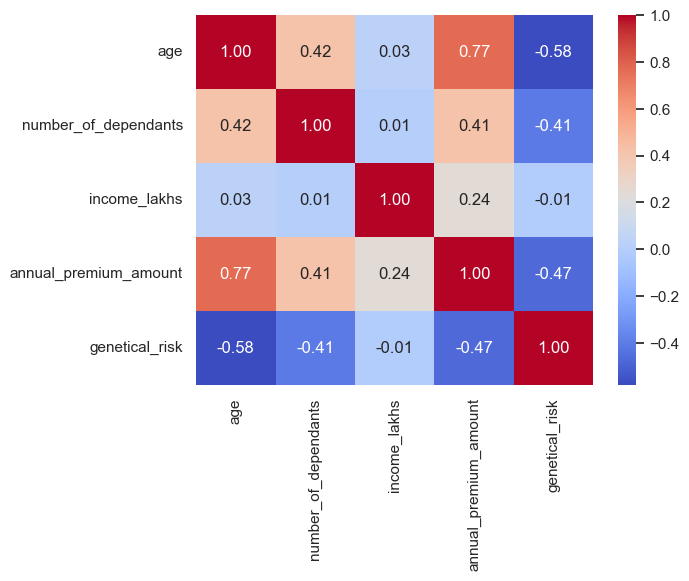

In [11]:
corr = df_clean.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f',cmap='coolwarm')
plt.show()

In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49908 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    49908 non-null  int64 
 1   gender                 49908 non-null  object
 2   region                 49908 non-null  object
 3   marital_status         49908 non-null  object
 4   number_of_dependants   49908 non-null  int64 
 5   bmi_category           49908 non-null  object
 6   smoking_status         49908 non-null  object
 7   employment_status      49908 non-null  object
 8   income_level           49908 non-null  object
 9   income_lakhs           49908 non-null  int64 
 10  medical_history        49908 non-null  object
 11  insurance_plan         49908 non-null  object
 12  annual_premium_amount  49908 non-null  int64 
 13  genetical_risk         49908 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 5.7+ MB


In [13]:
OUT_PATH = r'..\data\processed\cleaned.xlsx'

if not df_clean.empty:
    df_clean.to_excel(OUT_PATH, index=False)
    print(f'Cleaned dataset exported to {OUT_PATH}')
else:
    print('No cleaned dataset to export.')

Cleaned dataset exported to ..\data\processed\cleaned.xlsx
